In [1]:
%matplotlib inline

import os
import time
import math
import glob
import decimal
import datetime
import subprocess 
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from __future__ import unicode_literals
from IPython.core.display import display, HTML

In [2]:
# Load helper functions
%run plotter_fhelpers.py

In [3]:
# Global configurations
# ---------------------

# Module-specific settings
decimal.getcontext().prec = 6
pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-ticks')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 24
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['lines.linewidth'] = 2


# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Restore part of matplotlib 1.5 behavior
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['errorbar.capsize'] = 3

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

# Experiment setup

Directory structure for raw data:
```
* weak_scaling_[null|namd]_entk4/
    * [null|namd]-ws-[64|128|256|512|1024]cores-trial<int>/
        * rp.session.<string>.<string>.<int>.<int>/
            * pilot-0000/
            * rp.session.<string>.<string>.<int>.<int>.prof
        * rp.session.<string>.<string>.<int>.<int>-units-folder/
        * rp.session.<string>.<string>.<int>.<int>.prof
        * execution_profile_rp.session.<string>.<string>.<int>.<int>.csv
```

In [4]:
# Workload names and number of trials
workloads = {'null': 3, 'namd': 2}

# List of number of total cores at various data points
cores = [64, 128, 256, 512, 1024]

# Number of cores per task
ctask = 8

# Pilot name
pname = 'pilot.0000'

# Experiment directorie
def trial_name(wrkld,ncore,ntrial):
    return '%s-ws-%scores-trial%s/' % (wrkld, ncore, ntrial)

def trial_path(wrkld,ncore,ntrial):
    base_dir = 'weak_scaling_%s_entk4/' % wrkld
    run_dir = trial_name(wrkld,ncore,ntrial)
    return base_dir+run_dir

# Dataframe Workloads

In [5]:
df_workloads = pd.DataFrame(columns=['workload','npipeline','trial','TTR','TTX','EnTKO','RPO'])
df_tasks = pd.DataFrame()

for wname in workloads.keys():
    for core in cores:
        for trial in range(1,workloads[wname]+1):
            
            try:
                sid = glob.glob('%s/rp.session.*' % trial_path(wname,core,trial))[0]
            except:
                print 'WARNING: missing session at %s' % trial_path(wname,core,trial)
                continue
            
            # trial's number of pipelines
            t_pipeline = core/ctask
            
            # trial's name
            t_name = trial_name(wname, core, trial)[:-1]

            # trial's TTR
            t_ttr = extract_rp_tr(sid, pname)

            # trial's TTX
            if wname == 'null':
                t_ttx = 0.0
                t_s4_ttx = 0.0
                t_s5_ttx = 0.0
                t_s6_ttx = 0.0
            else:
                print core
                # extract RP Tx timestamps and NAMD Tx duration
                rp_txs = extract_rp_tx(sid)
                namd_txs = extract_namd_tx(sid, pname)
                
                if rp_txs.index.size != namd_txs.index.size:
                    print 'NOOOOOO'
                    
                if rp_txs.index.size != 7*t_pipeline:
                    print 'WARNING: extract_rp_tx(): npipelines: %s; number of tasks: %s: The number of tasks per pipeline is messed up!' % (t_pipeline, rp_txs.size)
                
                # Merge NAMD Tx duration with RP Tx timestamps
                txs = rp_txs.merge(namd_txs, right_index=True,left_index=True)
                txs.reset_index(inplace=True)
                if txs.index.size != 7*t_pipeline:
                    print 'WARNING: rp_txs.merge(): npipelines: %s; number of tasks: %s: The number of tasks per pipeline is messed up!' % (t_pipeline, txs.index.size)
                    
                txs.columns = ['uid','StartExecuting', 'StagingOutput', 'TxRP', 'Stage', 'TxNAMD']
                
                # Calculate the end timestamp of Tx on the base of NAMD logs
                txs['StopExecutingNAMD'] = txs['StartExecuting'] + txs['TxNAMD']

                # Calculate TTX from RP unit start timestamp and the unit stop timestamp derived from NAMD
                t_ttx = extract_rp_ttx(txs[['StartExecuting','StopExecutingNAMD']].copy())
                
                # Calculate TTX for dominant NAMD stages 4, 5, 6
                t_s4_ttx = extract_rp_ttx(txs[txs.Stage == 'stage_4'][['StartExecuting','StopExecutingNAMD']].copy())
                t_s5_ttx = extract_rp_ttx(txs[txs.Stage == 'stage_5'][['StartExecuting','StopExecutingNAMD']].copy())
                t_s6_ttx = extract_rp_ttx(txs[txs.Stage == 'stage_6'][['StartExecuting','StopExecutingNAMD']].copy())                
                
                # Save tasks timestamps to a dedicated DF
                if txs.index.size != 7*t_pipeline:
                    print 'WARNING: rp_txs.merge(): npipelines: %s; number of tasks: %s: The number of tasks per pipeline is messed up!' % (t_pipeline, txs.index.size)
                    display(txs)
                    
                txs['workload'] = wname
                txs['npipeline'] = t_pipeline                
                txs['trial'] = t_name
                df_tasks = df_tasks.append(txs)

            # trial's EnTK overhead
            t_path = trial_path(wname, core, trial)
            entk_csv = t_path+'enmd_pat_overhead.csv'
            t_entko = extract_entk_overhead(pd.read_csv(entk_csv, header=0, sep=',', skipinitialspace=True))

            # trial's RPO
            t_rpo = (t_ttr - t_ttx) - t_entko
            
            # store values to workload DataFrame
            df_workloads = df_workloads.append([{'workload' : wname,
                                                 'npipeline': t_pipeline,
                                                 'trial'    : t_name,
                                                 'TTR'      : t_ttr,
                                                 'TTX'      : t_ttx,
                                                 'TTXS4'    : t_s4_ttx,
                                                 'TTXS5'    : t_s5_ttx,
                                                 'TTXS6'    : t_s6_ttx,
                                                 'EnTKO'    : t_entko,
                                                 'RPO'      : t_rpo}], ignore_index=True)
display(df_workloads)
display(df_tasks)

64
64
128
128
256
256
512
512
1024
1024


,EnTKO,RPO,TTR,TTX,TTXS4,TTXS5,TTXS6,npipeline,trial,workload
0,0.097709,283.494391,283.5921,0.0000,0.0000,0.0000,0.0000,8,null-ws-64cores-trial1,null
1,0.100529,314.691871,314.7924,0.0000,0.0000,0.0000,0.0000,8,null-ws-64cores-trial2,null
2,0.104314,329.938486,330.0428,0.0000,0.0000,0.0000,0.0000,8,null-ws-64cores-trial3,null
3,0.200379,641.554721,641.7551,0.0000,0.0000,0.0000,0.0000,16,null-ws-128cores-trial1,null
4,0.212407,265.889593,266.1020,0.0000,0.0000,0.0000,0.0000,16,null-ws-128cores-trial2,null
5,0.217809,281.563291,281.7811,0.0000,0.0000,0.0000,0.0000,16,null-ws-128cores-trial3,null
6,0.437267,868.893933,869.3312,0.0000,0.0000,0.0000,0.0000,32,null-ws-256cores-trial1,null
7,0.386983,1893.537317,1893.9243,0.0000,0.0000,0.0000,0.0000,32,null-ws-256cores-trial2,null
8,0.448814,576.161386,576.6102,0.0000,0.0000,0.0000,0.0000,32,null-ws-256cores-trial3,null
9,0.892151,373.667249,374.5594,0.0000,0.0000,0.0000,0.0000,64,null-ws-512cores-trial1,null


,uid,StartExecuting,StagingOutput,TxRP,Stage,TxNAMD,StopExecutingNAMD,workload,npipeline,trial
0,unit.000000,2050.1520,2825.8121,775.6601,stage_1,0.125,2050.2770,namd,8,namd-ws-64cores-trial1
1,unit.000001,2050.1519,2825.2917,775.1398,stage_1,0.125,2050.2769,namd,8,namd-ws-64cores-trial1
2,unit.000002,2050.1518,2825.0873,774.9355,stage_1,0.125,2050.2768,namd,8,namd-ws-64cores-trial1
3,unit.000003,2046.9419,2825.4959,778.5540,stage_1,0.125,2047.0669,namd,8,namd-ws-64cores-trial1
4,unit.000004,2050.1522,2825.6121,775.4599,stage_1,0.125,2050.2772,namd,8,namd-ws-64cores-trial1
5,unit.000005,2050.1522,2825.4121,775.2599,stage_1,0.125,2050.2772,namd,8,namd-ws-64cores-trial1
6,unit.000006,2050.1521,2825.7005,775.5484,stage_1,0.125,2050.2771,namd,8,namd-ws-64cores-trial1
7,unit.000007,2050.1521,2825.8996,775.7475,stage_1,0.125,2050.2771,namd,8,namd-ws-64cores-trial1
8,unit.000008,2831.0847,3129.2199,298.1352,stage_2,0.125,2831.2097,namd,8,namd-ws-64cores-trial1
9,unit.000009,2831.0845,3141.4542,310.3697,stage_2,0.125,2831.2095,namd,8,namd-ws-64cores-trial1


In [6]:
# Drop ourlier at 32. Clearly off-scale, it probably measured
# an execution error.
df_workloads.drop(7, inplace=True)

# Plots

In [7]:
# Calculate mean and std for RP OverHead and EnTK OverHead
# as a function of the number of pipelines
null_overheads = df_workloads[
    df_workloads.workload == 'null'][
        ['npipeline','RPO','EnTKO','TTX','TTXS4','TTXS5','TTXS6']].groupby(
            ['npipeline']).aggregate(
                {'RPO'  : ['mean','std'],
                 'EnTKO': ['mean','std'],
                 'TTX'  : ['mean','std'],
                 'TTXS4': ['mean','std'],
                 'TTXS5': ['mean','std'],
                 'TTXS6': ['mean','std']})

namd_overheads = df_workloads[
    df_workloads.workload == 'namd'][
        ['npipeline','RPO','EnTKO','TTR','TTX','TTXS4','TTXS5','TTXS6']].groupby(
            ['npipeline']).aggregate(
                {'RPO'  : ['mean','std'],
                 'EnTKO': ['mean','std'],
                 'TTX'  : ['mean','std'],
                 'TTR'  : ['mean','std'],
                 'TTXS4': ['mean','std'],
                 'TTXS5': ['mean','std'],
                 'TTXS6': ['mean','std']})

display(null_overheads)
display(namd_overheads)

EnTKO            TTX      TTXS4      TTXS5      TTXS6              RPO            
               mean       std mean  std  mean  std  mean  std  mean  std        mean         std
npipeline                                                                                       
8          0.100851  0.003314  0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0  309.374916   23.674163
16         0.210198  0.008922  0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0  396.335868  212.510307
32         0.443041  0.008165  0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0  722.527660  206.993169
64         0.883182  0.016742  0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0  631.938285  246.164924
128        1.784178  0.017027  0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0  850.249356   84.699473

EnTKO                    TTX                     TTXS4                      TTR                     TTXS6                     TTXS5                       RPO             
               mean       std         mean          std         mean          std        mean          std         mean          std         mean          std         mean          std
npipeline                                                                                                                                                                               
8          0.066371  0.019516  28020.81610   400.588012   3152.02170   429.613332  36776.9268  2826.065812   4579.01635   430.200867  22274.81240   924.413706  8756.044329  2425.497316
16         0.171709  0.024084  36328.97765   808.354785   5013.53690   808.933552  38298.8855  1485.796103   8839.82370  1407.153808  32925.65270  1289.732080  1969.736141  2294.126804
32         0.401528  0.043095  37278.52395  1002.940389   8272.37005   397.927099  39257.4591  1044.877548  14544.29740   972.019528  34424.63560   624.394097  1978.533622    41.980255
64         0.738699  0.013067  38397.50710   694.483087  10358.02440  1256.512345  39217.1929  1569.419117  21745.90545  2547.330330  36311.42055   525.139427   818.947101   874.949097
128        1.681551  0.103776  38976.43400  1544.257571  12915.26585   495.545028  41346.2896  3558.876774  26441.31275   779.040825  35976.93840   822.542387  2368.174049  2014.515427

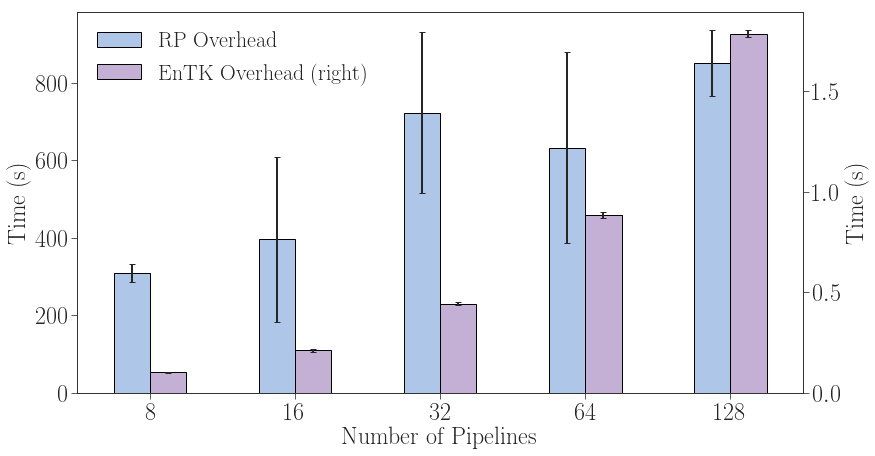

In [8]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

# title_head = 'NCSA: Blue Waters'
# title_work = 'Null HTBAC workload: 7 stages; 1 task each stage; 0 execution time' 
# title_desc = 'RADICAL-Pilot and RADICAL-EnTK overheads'
# title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
# fig.suptitle(title, y=1.05)

# Plot means and std bars
null_overheads['RPO'].reset_index().plot(
    x='npipeline', 
    y='mean', 
    yerr='std',
    position=1,
    width=0.25,
    color=tableau20[1],
    ax=ax,
    rot=0,
    label='RP Overhead',
    kind='bar')

null_overheads['EnTKO'].reset_index().plot(
    x='npipeline', 
    y='mean', 
    yerr='std',
    secondary_y=True,
    position=0,
    width=0.25,
    rot=0,
    color=tableau20[9],
    ax=ax,
    label='EnTK Overhead',
    kind='bar')


ax.set_xlabel('Number of Pipelines')
ax.set_ylabel('Time (s)')
ax.right_ax.set_ylabel('Time (s)')
ax.set_xlim(-0.5)

plt.savefig('figures/null_workload_overheads.pdf', dpi=600, bbox_inches='tight')

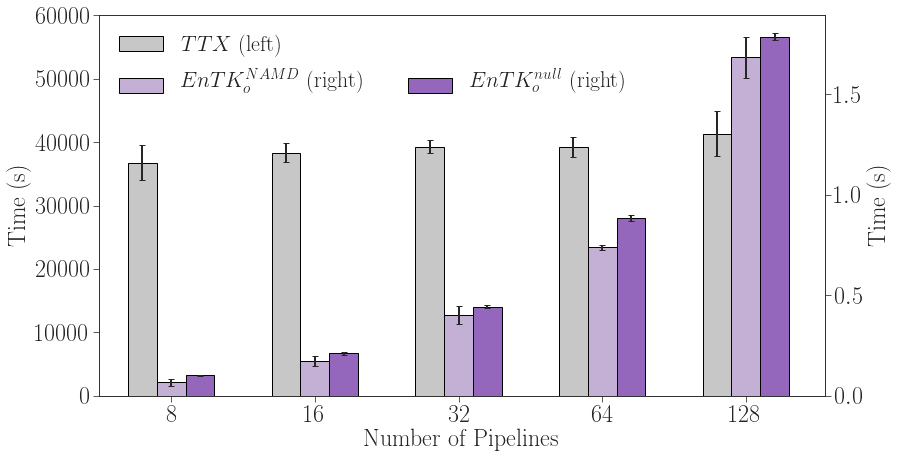

In [9]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

# title_head = 'NCSA: Blue Waters'
# title_work = 'NAMD HTBAC workload: 7 stages; 4 NAMD stages; 1 task each stage' 
# title_desc = 'NAMD Execution time ($T_x$); RADICAL-Pilot and RADICAL-EnTK overheads'
# title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
# fig.suptitle(title, y=1.2)

# Plot means and std bars

# namd_overheads['TTX'].reset_index().plot(kind='bar',
#     x='npipeline', 
#     y='mean', 
#     yerr='std',
#     label='NAMD $T_x$',
#     color=tableau20[0], position=1.5, width=0.20, rot=0, ax=ax)

# namd_overheads['TTXS5'].reset_index().plot(kind='bar',
#     x='npipeline', 
#     y='mean', 
#     label='NAMD $T_x^{s5}$',
#     color=tableau20[2], position=1.5, width=0.20, rot=0, ax=ax)

# namd_overheads['TTXS6'].reset_index().plot(kind='bar',
#     x='npipeline', 
#     y='mean', 
#     label='NAMD $T_x^{s6}$',
#     color=tableau20[3], position=1.5, width=0.20, rot=0, ax=ax)

# namd_overheads['TTXS4'].reset_index().plot(kind='bar',
#     x='npipeline', 
#     y='mean', 
#     label='NAMD $T_x^{s4}$',
#     color=tableau20[6], position=1.5, width=0.20, rot=0, ax=ax)

# namd_overheads['RPO'].reset_index().plot(kind='bar',
#     x='npipeline', 
#     y='mean', 
#     yerr='std',
#     label='RP Overhead',
#     color=tableau20[0], position=2.5, width=0.20, rot=0, ax=ax)

namd_overheads['TTR'].reset_index().plot(kind='bar',
    x='npipeline', 
    y='mean', 
    yerr='std',
    label='$TTX$ (left)',
    color=tableau20[23], position=1.5, width=0.20, rot=0, ax=ax)

namd_overheads['EnTKO'].reset_index().plot(kind='bar',
    x='npipeline', 
    y='mean', 
    yerr='std',
    label='$EnTK_o^{NAMD}$ (right)',
    secondary_y=True, 
    color=tableau20[9], position=0.5, width=0.20, rot=0, ax=ax)

null_overheads['EnTKO'].reset_index().plot(kind='bar',
    x='npipeline', 
    y='mean', 
    yerr='std',
    label='$EnTK_o^{null}$ (right)',
    secondary_y=True,
    color=tableau20[8], position=-0.5, width=0.20, rot=0, ax=ax)

ax.legend(loc='upper left', ncol=3)
plt.legend(loc='upper left', ncol=3, bbox_to_anchor=(0, 0.9))

ax.set_xlabel('Number of Pipelines')
ax.set_ylabel('Time (s)')
ax.right_ax.set_ylabel('Time (s)')
ax.set_xlim(-0.5)
ax.set_ylim(0,60000)

plt.savefig('figures/namd_null_workload_overheads.pdf', dpi=600, bbox_inches='tight')

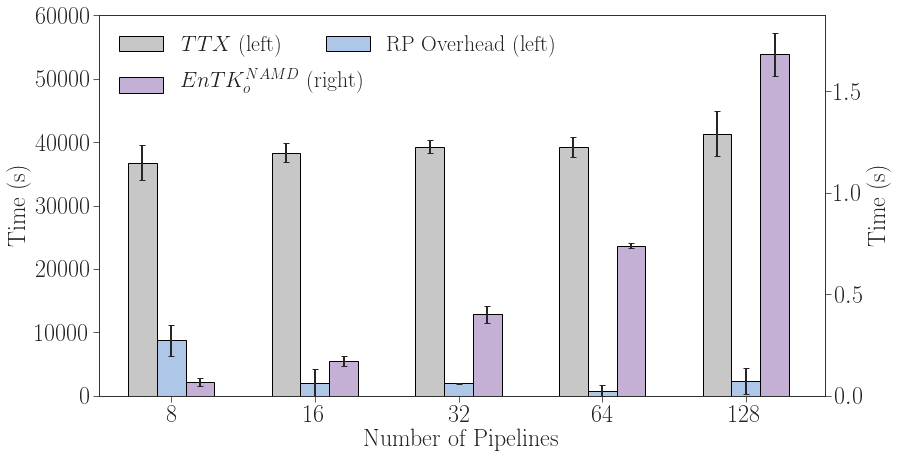

In [10]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

# title_head = 'NCSA: Blue Waters'
# title_work = 'NAMD HTBAC workload: 7 stages; 4 NAMD stages; 1 task each stage' 
# title_desc = 'NAMD Execution time ($T_x$); RADICAL-Pilot and RADICAL-EnTK overheads'
# title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
# fig.suptitle(title, y=1.2)

# Plot means and std bars

# namd_overheads['TTX'].reset_index().plot(kind='bar',
#     x='npipeline', 
#     y='mean', 
#     yerr='std',
#     label='NAMD $T_x$',
#     color=tableau20[0], position=1.5, width=0.20, rot=0, ax=ax)

# namd_overheads['TTXS5'].reset_index().plot(kind='bar',
#     x='npipeline', 
#     y='mean', 
#     label='NAMD $T_x^{s5}$',
#     color=tableau20[2], position=1.5, width=0.20, rot=0, ax=ax)

# namd_overheads['TTXS6'].reset_index().plot(kind='bar',
#     x='npipeline', 
#     y='mean', 
#     label='NAMD $T_x^{s6}$',
#     color=tableau20[3], position=1.5, width=0.20, rot=0, ax=ax)

# namd_overheads['TTXS4'].reset_index().plot(kind='bar',
#     x='npipeline', 
#     y='mean', 
#     label='NAMD $T_x^{s4}$',
#     color=tableau20[6], position=1.5, width=0.20, rot=0, ax=ax)

namd_overheads['TTR'].reset_index().plot(kind='bar',
    x='npipeline', 
    y='mean', 
    yerr='std',
    label='$TTX$ (left)',
    color=tableau20[23], position=1.5, width=0.20, rot=0, ax=ax)

namd_overheads['RPO'].reset_index().plot(kind='bar',
    x='npipeline', 
    y='mean', 
    yerr='std',
    label='RP Overhead (left)',
    color=tableau20[1], position=0.5, width=0.20, rot=0, ax=ax)

namd_overheads['EnTKO'].reset_index().plot(kind='bar',
    x='npipeline', 
    y='mean', 
    yerr='std',
    label='$EnTK_o^{NAMD}$ (right)',
    secondary_y=True, 
    color=tableau20[9], position=-0.5, width=0.20, rot=0, ax=ax)

ax.legend(loc='upper left', ncol=3)
plt.legend(loc='upper left', ncol=3, bbox_to_anchor=(0, 0.9))

ax.set_xlabel('Number of Pipelines')
ax.set_ylabel('Time (s)')
ax.right_ax.set_ylabel('Time (s)')
ax.set_xlim(-0.5)
ax.set_ylim(0,60000)

plt.savefig('figures/namd_workload_overheads.pdf', dpi=600, bbox_inches='tight')

In [11]:
# Mean execution time per stage across all trials.
# namd_tx_means = df_tasks[
#         ['Stage','TxNAMD']].groupby(
#             ['Stage']).aggregate(
#                 {'TxNAMD'  : ['mean','std']})

namd_tx8_means = df_tasks[df_tasks.npipeline == 8][
        ['Stage','TxNAMD']].groupby(
            ['Stage']).aggregate(
                {'TxNAMD'  : ['mean','std']})

namd_tx16_means = df_tasks[df_tasks.npipeline == 16][
        ['Stage','TxNAMD']].groupby(
            ['Stage']).aggregate(
                {'TxNAMD'  : ['mean','std']})

namd_tx32_means = df_tasks[df_tasks.npipeline == 32][
        ['Stage','TxNAMD']].groupby(
            ['Stage']).aggregate(
                {'TxNAMD'  : ['mean','std']})

namd_tx64_means = df_tasks[df_tasks.npipeline == 64][
        ['Stage','TxNAMD']].groupby(
            ['Stage']).aggregate(
                {'TxNAMD'  : ['mean','std']})

namd_tx128_means = df_tasks[df_tasks.npipeline == 128][
        ['Stage','TxNAMD']].groupby(
            ['Stage']).aggregate(
                {'TxNAMD'  : ['mean','std']})

namd_tx8_means.rename_axis({'TxNAMD':'p8'}, axis='columns', inplace=True)
namd_tx16_means.rename_axis({'TxNAMD':'p16'}, axis='columns', inplace=True)
namd_tx32_means.rename_axis({'TxNAMD':'p32'}, axis='columns', inplace=True)
namd_tx64_means.rename_axis({'TxNAMD':'p64'}, axis='columns', inplace=True)
namd_tx128_means.rename_axis({'TxNAMD':'p128'}, axis='columns', inplace=True)

namd_tx_means = pd.concat([namd_tx8_means,
                           namd_tx16_means,
                           namd_tx32_means,
                           namd_tx64_means,
                           namd_tx128_means], axis=1)

namd_tx_means.index = ['Stage 1','Stage 2','Stage 3','Stage 4','Stage 5','Stage 6','Stage 7']
namd_tx_means.index.rename('Stage', inplace=True)
display(namd_tx_means)

p8                     p16                    p32                    p64                    p128           
                mean        std         mean       std         mean       std         mean        std         mean        std
Stage                                                                                                                        
Stage 1     0.125000   0.000000     0.125000  0.000000     0.125000  0.000000     0.125000   0.000000     0.125000   0.000000
Stage 2     0.125000   0.000000     0.125000  0.000000     0.125000  0.000000     0.125000   0.000000     0.125000   0.000000
Stage 3   741.859375   0.993599   742.335938  1.442597   741.988281  1.141245   741.915039   1.373427   742.358398   3.734605
Stage 4   554.601562   1.871507   553.957031  0.828310   554.146484  0.922211   554.279297   2.715264   554.104980   0.801211
Stage 5  6640.070312  11.556020  6642.210938  9.478352  6637.574219  8.571875  6638.263672  13.386427  6638.897461  10.531040
Stage 6   624.304688   2.044795   624.097656  1.791201   623.910156  1.258398   624.463867   1.874124   624.085449   1.672686
Stage 7     0.375000   0.000000     0.375000  0.000000     0.375000  0.000000     0.375000   0.000000     0.375000   0.000000

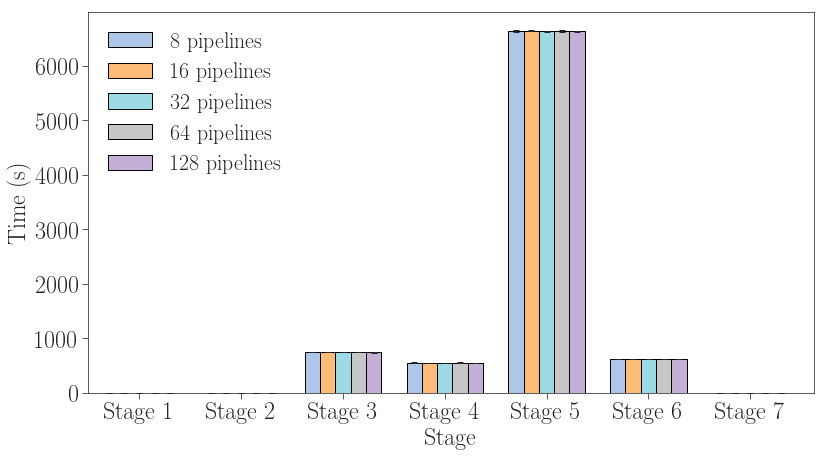

In [12]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)

# Plot means and std bars
namd_tx_means['p8'].reset_index().plot(kind='bar',
    x='Stage', 
    y='mean', 
    yerr='std',
    label='8 pipelines',
    color=tableau20[1], position=2.5, width=0.15, rot=0, ax=ax)

namd_tx_means['p16'].reset_index().plot(kind='bar',
    x='Stage', 
    y='mean', 
    yerr='std',
    label='16 pipelines',
    color=tableau20[3], position=1.5, width=0.15, rot=0, ax=ax)

namd_tx_means['p32'].reset_index().plot(kind='bar',
    x='Stage', 
    y='mean', 
    yerr='std',
    label='32 pipelines',
    color=tableau20[17], position=0.5, width=0.15, rot=0, ax=ax)

namd_tx_means['p64'].reset_index().plot(kind='bar',
    x='Stage', 
    y='mean', 
    yerr='std',
    label='64 pipelines',
    color=tableau20[23], position=-0.5, width=0.15, rot=0, ax=ax)

namd_tx_means['p128'].reset_index().plot(kind='bar',
    x='Stage', 
    y='mean', 
    yerr='std',
    label='128 pipelines',
    color=tableau20[9], position=-1.5, width=0.15, rot=0, ax=ax)


ax.set_ylabel('Time (s)')
ax.set_xlim(-0.5)

plt.savefig('figures/namd_average_tx.pdf', dpi=600, bbox_inches='tight')

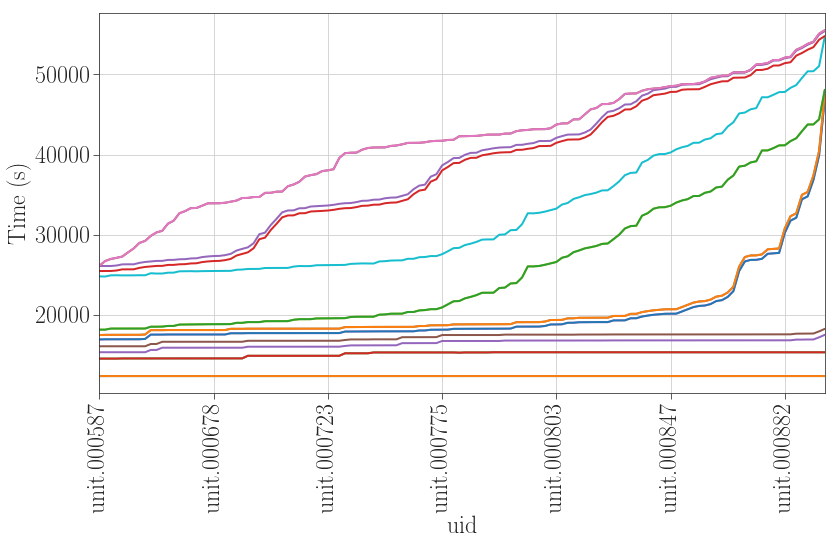

In [13]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)

cores = 1024
pipelines = 128

# Plot means and std bars
df_tasks[(df_tasks.trial == 'namd-ws-%scores-trial1' % cores) &
         (df_tasks.Stage == 'stage_1') &
         (df_tasks.npipeline == pipelines)][
            ['uid',
             'StartExecuting',
             'StopExecutingNAMD']].plot(
                x='uid', 
                rot=90, 
                ax=ax)

df_tasks[(df_tasks.trial == 'namd-ws-%scores-trial1' % cores) &
         (df_tasks.Stage == 'stage_2') &
         (df_tasks.npipeline == pipelines)][['uid','StartExecuting','StopExecutingNAMD']].plot(x='uid', rot=90, ax=ax)

df_tasks[(df_tasks.trial == 'namd-ws-%scores-trial1' % cores) &
         (df_tasks.Stage == 'stage_3') &
         (df_tasks.npipeline == pipelines)][['uid','StartExecuting','StopExecutingNAMD']].plot(x='uid', rot=90, ax=ax)

df_tasks[(df_tasks.trial == 'namd-ws-%scores-trial1' % cores) &
         (df_tasks.Stage == 'stage_4') &
         (df_tasks.npipeline == pipelines)][['uid','StartExecuting','StopExecutingNAMD']].plot(x='uid', rot=90, ax=ax)

df_tasks[(df_tasks.trial == 'namd-ws-%scores-trial1' % cores) &
         (df_tasks.Stage == 'stage_5') &
         (df_tasks.npipeline == pipelines)][['uid','StartExecuting','StopExecutingNAMD']].plot(x='uid', rot=90, ax=ax)

df_tasks[(df_tasks.trial == 'namd-ws-%scores-trial1' % cores) &
         (df_tasks.Stage == 'stage_4') &
         (df_tasks.npipeline == pipelines)][['uid','StartExecuting', 'StopExecutingNAMD']].plot(x='uid', rot=90, ax=ax, grid=True)

df_tasks[(df_tasks.trial == 'namd-ws-%scores-trial1' % cores) &
         (df_tasks.Stage == 'stage_5') &
         (df_tasks.npipeline == pipelines)][['uid','StartExecuting']].plot(x='uid', rot=90, ax=ax,  grid=True)

df_tasks[(df_tasks.trial == 'namd-ws-%scores-trial1' % cores) &
         (df_tasks.Stage == 'stage_6') &
         (df_tasks.npipeline == pipelines)][['uid','StartExecuting','StopExecutingNAMD']].plot(x='uid', rot=90, ax=ax)

df_tasks[(df_tasks.trial == 'namd-ws-%scores-trial1' % cores) &
         (df_tasks.Stage == 'stage_7') &
         (df_tasks.npipeline == pipelines)][['uid','StartExecuting','StopExecutingNAMD']].plot(x='uid', rot=90, ax=ax, grid=True)

ax.legend('')
ax.set_ylabel('Time (s)')

plt.savefig('figures/namd_concurrency_tx.pdf', dpi=600, bbox_inches='tight')